## Tutorial: Combining adjoint sensitivities with emissions data to calculate air quality impacts
### Example: LA County

In this tutorial we will demonstrate how to combine results from the GEOS-Chem adjoint, known as sensitivities, with emisisons data from the US EPA's National Emission Inventory (NEI) to determine how different emission scenarios would impact air quality in Los Angles, CA. 

First, we will confirm that you have the correct files needed to perform this tutorial. You should have four netcdf files in this folder. Three sensitivity files of the form:

>la_sens_no.nc <br>
la_sens_o3.nc <br>
la_sens_pm.nc <br>
>

And eleven emissions files each of the form:

> nei_emis_onroad.nc

For each of the emissions files the component of the filename following "nei_emis_" will indicate the sector. For both the sensitivities and files there will be date and time information in the filenames to indicate when the file was created. These files should be stored in the same directory as this tutorial.

We will present a quick example of how these files can be used. We will check to make sure these files are in the current directory but first we need to load in the python libraries we'll be using.

In [1]:

# for this tutorial we will use netCDF4, xarray, numpy, os, and matplotlib.pyplot
import netCDF4 as nc
import xarray as xr
import numpy as np
import os
import matplotlib.pyplot as plt
import datetime


Let's take a look at the files in the current directory. We'll also store specific filenames used in this tutorial in variables.

In [2]:
# get a list of the files in the current directory
files = os.listdir('.')

# loop through these files
for name in files: 
    if name.endswith('.nc'): 
        # print all files ending with the netcdf extension (.nc)
        print(name)
        # save the filenames into variables for the pm2.5 sensitivity file and the onroad_catx emission file
        if "_pm" in name: pm_sens_filename = name
        if "_onroad_catx" in name: on_road_emis_filename = name            
    

la_sens_no_19112021_080520.nc
la_sens_o3_19112021_080452.nc
la_sens_pm_19112021_080507.nc
nei_emis_ag_19112021_082921.nc
nei_emis_c3marine_19112021_082923.nc
nei_emis_egu_19112021_082925.nc
nei_emis_egupk_19112021_082933.nc
nei_emis_nonroad_19112021_082936.nc
nei_emis_oilgas_19112021_082938.nc
nei_emis_onroad_19112021_082940.nc
nei_emis_onroad_catx_19112021_082946.nc
nei_emis_othpt_19112021_082948.nc
nei_emis_ptnonipm_19112021_082951.nc
nei_emis_sf_19112021_082953.nc


You should see 14 files listed above: 11 emissions files and 3 sensitivity files. For the purpose fo this tutorial we will focus on just two of these files, the pm sensitivity file and the onroad catx emissions file. Let's read in data from the latter first and print out info from the file:

In [3]:
# read in emissions data from the onroad_catx file
emissions = xr.open_dataset(on_road_emis_filename)

# print out all of the metadata of this xarray dataset
print(emissions.info())

xarray.Dataset {
dimensions:
	lat = 89 ;
	lon = 91 ;
	time = 396 ;

variables:
	float64 lon(lon) ;
		lon:units = degrees_east ;
		lon:long_name = longitude ;
		lon:comment = centre of grid cell ;
	float64 lat(lat) ;
		lat:units = degrees_north ;
		lat:long_name = latitude ;
		lat:comment = centre of grid cell ;
	datetime64[ns] time(time) ;
		time:long_name = reference time of sst field ;
		time:comment =  ;
		time:axis = T ;
	float64 BC(time, lat, lon) ;
		BC:long_name = emissions of BC ;
		BC:units = (kg / m2 / s) ;
	float64 OC(time, lat, lon) ;
		OC:long_name = emissions of OC ;
		OC:units = (kg / m2 / s) ;
	float64 NH3(time, lat, lon) ;
		NH3:long_name = emissions of NH3 ;
		NH3:units = (kg / m2 / s) ;
	float64 NOx(time, lat, lon) ;
		NOx:long_name = emissions of NOx ;
		NOx:units = (kg / m2 / s) ;
	float64 SO2(time, lat, lon) ;
		SO2:long_name = emissions of SO2 ;
		SO2:units = (kg / m2 / s) ;
	float64 SOAP(time, lat, lon) ;
		SOAP:long_name = emissions of SOAP ;
		SOAP:units = (kg


<br>
Each of the variables stored in this file represent a chemical precursor species of one of the three pollutants ($PM_{2.5}$, $O_3$, $NO_2$). Each of these species have three dimensions, one of latitude (89 grid cells), one of longitude (91 grid cells), and one of time (396 days). In this tutorial we will only consider NOx emissions.

In the previous step, you'll notice we read in emissions from the "onroad_catx" file. So all of the emissions in this file are specifically emissions from the "on-road" sector in California and Texas.

Next we will store the coordinate data, time data, and NOx emissions from this dataset into seperate variables. For this first step of the tutorial let's just look at emissions from a specific day. I've arbitrarily chosen July 1st, 2011 but feel free to try out any day in the date range.

In [6]:
# choose a year, month, and day from December 1st, 2010 to December 31st, 2011
year = 2011
month = 7
day = 1
# create a datetime variable based on this information
date = datetime.datetime(year,month,day)

# store time data into variable
time = emissions.time

# get index for given day
day_index = np.where(time == np.datetime64(date))

# if day index is out of range replace with July 1st, 2011
if (day_index[0].size) == 0: day_index = 212

# store coordinate data into variables
lat = emissions.lat
lon = emissions.lon

# store emissions data into a variable
nox_emis = emissions.NOx[day_index[0],:,:].squeeze()


Now that we've stored the coordinate data and emissions data into seperate variables let's plot our emissions data.

(30.0, 45.0)

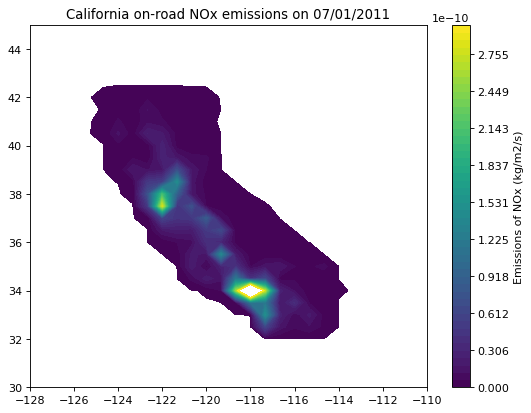

In [7]:
# create a meshgrid based on the coordinate data for the purpose of plotting
X, Y = np.meshgrid(lon, lat)

# define contour levels
levels = np.linspace(1E-14,3E-10,50)

# create figure
plt.figure(figsize=(8, 6), dpi=80)

# plot contour
cf = plt.contourf(X,Y,nox_emis,levels=levels)
# plot colorbar
cb = plt.colorbar()

plt.title('California on-road NOx emissions on '+date.strftime('%m/%d/%Y'))
cb.set_label('Emissions of NOx (kg/m2/s)')

# limit figure extent to california
plt.xlim(-128,-110)
plt.ylim(30,45)

We can see a map of California with large on-road emissions in high population areas like Los Angeles and the bay area.

Let's now load in the adjoint sensitivities  just for $PM_{2.5}$. This filename was stored earlier in the "pm_sens_filename" variable.

In [8]:
# read in adjoint sensitiviyt fo PM2.5 to precursor species
pm_sens = xr.open_dataset(pm_sens_filename)

# print out datset information
print(pm_sens.info())

xarray.Dataset {
dimensions:
	lat = 89 ;
	lon = 91 ;
	time = 396 ;

variables:
	float64 lon(lon) ;
		lon:units = degrees_east ;
		lon:long_name = longitude ;
		lon:comment = centre of grid cell ;
	float64 lat(lat) ;
		lat:units = degrees_north ;
		lat:long_name = latitude ;
		lat:comment = centre of grid cell ;
	datetime64[ns] time(time) ;
		time:long_name = reference time of sst field ;
		time:comment =  ;
		time:axis = T ;
	float64 BC_PM(time, lat, lon) ;
		BC_PM:long_name = daily sensitivity of BC_PM ;
		BC_PM:units = (ppbv) / (kg / m2 / s) ;
	float64 OC_PM(time, lat, lon) ;
		OC_PM:long_name = daily sensitivity of OC_PM ;
		OC_PM:units = (ppbv) / (kg / m2 / s) ;
	float64 NH3_PM(time, lat, lon) ;
		NH3_PM:long_name = daily sensitivity of NH3_PM ;
		NH3_PM:units = (ppbv) / (kg / m2 / s) ;
	float64 NOx_PM(time, lat, lon) ;
		NOx_PM:long_name = daily sensitivity of NOx_PM ;
		NOx_PM:units = (ppbv) / (kg / m2 / s) ;
	float64 SO2_PM(time, lat, lon) ;
		SO2_PM:long_name = daily sensitivit

You'll see a list of variables here indicating the sensitivity of $PM_{2.5}$ to various chemical species. Note these variables are in the same units as the NEI emissions.

Though for this example we will focus just on the sensitivity of $PM_{2.5}$ to NOx, you can consider the sensitivity of $PM_{2.5}$ to other chemical speciies by using the corresponding variables in this file. Let's isolate the NOx sensitivity for the same day that we chose earlier and plot the sensitivity.

(30.0, 45.0)

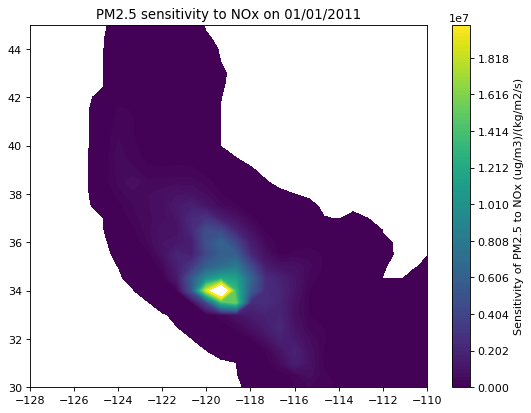

In [9]:
# store NOx sensitivity and remove empty index
nox_sens = pm_sens.NOx_PM[day_index[0],:,:].squeeze()

# create figure
plt.figure(figsize=(8, 6), dpi=80)

# specify contour levels for plot
levels = np.linspace(1E2,2E7,100)
# plot figure and colorbar
cf = plt.contourf(X,Y,nox_sens,levels=levels)
cb = plt.colorbar()

plt.title('PM2.5 sensitivity to NOx on 01/01/2011')
cb.set_label('Sensitivity of PM2.5 to NOx (ug/m3)/(kg/m2/s)')

# limit domain to California
plt.xlim(-128,-110)
plt.ylim(30,45)

You can see there is a high sensitivity area in the grid cell containing LA. These hotspots indicate areas where emissions contribute more to LA's annual average $PM_{2.5}$ exposure (on a given day).

If we combine the sensitivities here with the emissions discussed previously we can calculate how much emissions on our chosen day contributed to $PM_{2.5}$ in LA.

Let's do that now:

In [12]:
# combine the sensitivities and emissions
cont = np.multiply(nox_emis,nox_sens)

So how much did emissions from this day contribute to annual average PM2.5 exposure in LA? Let's find out:

In [24]:
# get the total number of contributions by summing over space
total = cont.sum().data

print("On-road emissions of NOx on %s contributed %0.3f ug/m3 to annual average PM2.5 exposure in LA." % (date,total))


On-road emissions of NOx on 2011-07-01 00:00:00 contributed 0.029 ug/m3 to annual average PM2.5 exposure in LA.


Naturally, let's extend this calculation to all days of the year in order to estimate how much on-road emissions from California contributed to LA's $PM_{2.5}$ exposure.

In [25]:
# get NOx emissions from all days
nox_emis = emissions.NOx[:,:,:]

# get PM2.5 sensitivities to NOx for all days
nox_sens = pm_sens.NOx_PM[:,:,:]

# combine the sensitivities and emissions and sum over space
cont = np.multiply(nox_emis,nox_sens)
total = cont.sum().data

print("In 2011, on-road emissions of NOx contributed %0.3f ug/m3 to annual average PM2.5 exposure in LA." % (total))

In 2011, on-road emissions of NOx contributed 1.311 ug/m3 to annual average PM2.5 exposure in LA.


## Running emission scenarios

In the previous section we looked at how we can estimate the amount different sectors contribute to a pollutant exposure. In this section we introduce a simple extension and demonstrate how to consider the impact of an emission scenario on a specific air pollutant.

Let's generate a test emission scenario where on-road NOx emissions from California are reduced by some amount for every day in the year. Specify some percentage to scale emissions between 0% and 200%.

In [26]:
# specify emission scenario scaling
user_scaling = 150

# apply scaling to emissions by converting percentage to relative scale
nox_emis = emissions.NOx[:,:,:] * user_scaling / 100

Now, as we did previously, let's combine these emissions with sensitivities to estimate the impact of the proposed emission scenario:

In [28]:
# combine the sensitivities and emissions and sum over space
cont = np.multiply(nox_emis,nox_sens)
total = cont.sum().data

print("An increase of on-road emissions of NOx by %d%% increases PM2.5 by %0.3f ug/m3." % (user_scaling,total))

An increase of on-road emissions of NOx by 150% increases PM2.5 by 1.967 ug/m3.


We can also consider scenarios where emissions are reduced. Specify some percentage between -100% and 0%:

In [29]:
# specify emission scenario scaling
user_scaling = -50

# apply scaling to emissions by converting percentage to relative scale
nox_emis = emissions.NOx[:,:,:] * user_scaling / 100

# combine the sensitivities and emissions and sum over space
cont = np.multiply(nox_emis,nox_sens)
total = cont.sum().data

print("A decrease of on-road NOx emissions by %d%% reduces PM2.5 by %0.3f ug/m3." % (user_scaling,total))

A decrease of on-road NOx emissions by -50% reduces PM2.5 by -0.656 ug/m3.


In the prior examples we considered scenarios using emissions data from all days of the year. But we can also assess air pollution impacts based on emission scenarios across different time periods. For example, what would happen if on-road emissions in California on Saturdays increased by 15%?

In [30]:
# specify emission scenario scaling
user_scaling = +15

# get NOx emissions from all saturdays (December 4th 2010 was a saturday, indexing every seven days)
nox_emis = emissions.NOx[4:-1:7,:,:] * user_scaling / 100

# get PM2.5 sensitivities to NOx for all days
nox_sens = pm_sens.NOx_PM[4:-1:7,:,:]

# combine the sensitivities and emissions and sum over space
cont = np.multiply(nox_emis,nox_sens)
total = cont.sum().data

print("An increase of on-road NOx emissions on Saturdays by %d%% increases PM2.5 by %0.3f ug/m3." % (user_scaling,total))

An increase of on-road NOx emissions on Saturdays by 15% increases PM2.5 by 0.029 ug/m3.


Lastly, we can also consider scenarios from specific locations. Emission scenarios can be run over any subset of grid cells, for the below example I will consider Los Angeles but feel free to choose any grid cell in the domain by changing the lat_location and lon_location variables.

In [33]:
# choose latitude and longitude coordinate
lat_location = 34.05
lon_location = -118.24

# find the grid cell that contains the above point.
lat_index = np.abs(lat - lat_location).argmin()
lon_index = np.abs(lon - lon_location).argmin()

# specify emission scenario scaling
user_scaling = 25

# apply scaling to emissions and isolate specific grid cell
nox_emis = emissions.NOx[:,lat_index,lon_index] * user_scaling / 100

# get PM2.5 sensitivities to NOx for all days
nox_sens = pm_sens.NOx_PM[:,lat_index,lon_index]

# combine the sensitivities and emissions and sum over space
cont = np.multiply(nox_emis,nox_sens)
total = cont.sum().data

print("An increase of on-road NOx emissions from (%0.2f°,%0.2f°) by %d%% increases PM2.5 by %0.3f ug/m3." % (lat_location,lon_location,user_scaling,total))

An increase of on-road NOx emissions from (34.05°,-118.24°) by 25% increases PM2.5 by 0.014 ug/m3.


This concludes the tutorial on combining adjoint sensitivities with emissions. All of the information given here can be extended to any of the eleven sectors or the six other precursor species of $PM_{2.5}$. Additionally these examples apply to the sensitivities calculated for $O_3$ and $NO_2$ and their respective precursor species. 